In [1]:
# penguin_nn_logistic_equivalent.py
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the penguins dataset
penguins = sns.load_dataset('penguins')
# Drop rows with missing values
penguins.dropna(inplace=True)
# Features
#X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
X = penguins[['bill_length_mm', 'bill_depth_mm']]
# Target: 1 if Adelie, 0 otherwise
y = (penguins['species'] == 'Adelie').astype(int)

In [3]:
#scaler = StandardScaler()
#X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X= X / X.max()

In [4]:
lambda_keras = 0.5  # for C=5

model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(1,
        activation='sigmoid',
        use_bias=False
        #kernel_regularizer=regularizers.l2(lambda_keras) 
    )
])


In [5]:
class AccuracyThreshold(Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        if acc is not None:
            if acc >= self.threshold:
                print(f"\nReached accuracy {acc:.3f} >= {self.threshold}, stopping training.")
                self.model.stop_training = True

# Instantiate callback
acc_stop = AccuracyThreshold(threshold=0.98198)

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

In [7]:
# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Train model
history = model.fit(X, y, epochs=10000, verbose=1, callbacks=[acc_stop])

Epoch 1/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4384 - loss: 0.9838  
Epoch 2/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4384 - loss: 0.9550 
Epoch 3/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4384 - loss: 0.9265 
Epoch 4/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4384 - loss: 0.9003 
Epoch 5/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4384 - loss: 0.8755 
Epoch 6/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4384 - loss: 0.8532 
Epoch 7/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4384 - loss: 0.8327 
Epoch 8/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4384 - loss: 0.8142 
Epoch 9/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4384 - loss: 0.7960 
Epoch 10/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4384 - loss: 0.7797 
Epoch 11/10000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4384 - loss: 0.7662 
Epoch 12/10000
11/11 ━━━━━━━━

In [9]:
train_acc_tf = history.history["accuracy"][-1]
print(train_acc_tf)

0.9819819927215576


In [10]:
# Get weights (no bias)
weights = model.get_weights()[0]  # shape (n_features, 1)

print("Model Coefficients:")
for feature, coef in zip(X.columns, weights.flatten()):
    print(f"{feature}: {coef:.4f}")

Model Coefficients:
bill_length_mm: -5.3592
bill_depth_mm: 4.5794


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step


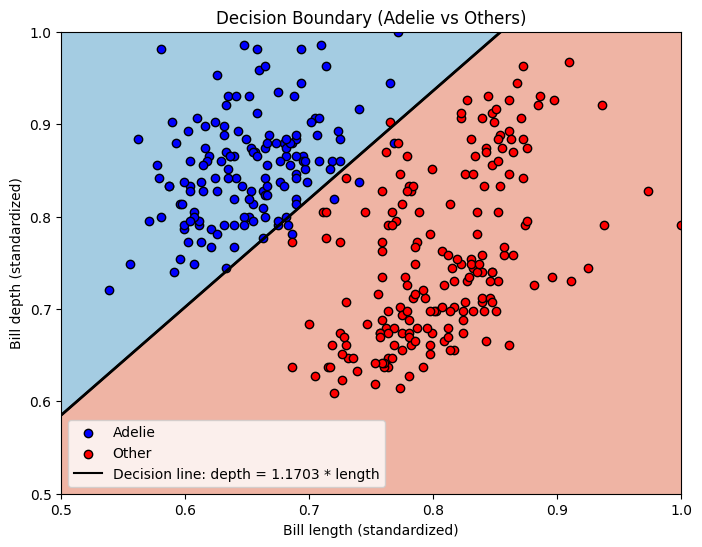

In [11]:
x_min=0.5
x_max=1 #= X['bill_length_mm'].min(), X['bill_length_mm'].max()
y_min=0.5 
y_max=1 #= X['bill_depth_mm'].min(), X['bill_depth_mm'].max()

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

w = model.layers[0].get_weights()[0]
slope = -w[0] / w[1]
x_vals = np.array([x_min, x_max])
y_vals = slope * x_vals
slope = (-w[0] / w[1]).item()

# Predict probabilities across the grid
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=1, cmap='RdBu', alpha=0.6)
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

# Add scatter plot of the data
y = pd.Series(y, index=X.index)  # ensure same index
plt.scatter(X.loc[y==1, 'bill_length_mm'], X.loc[y==1, 'bill_depth_mm'],
            c='blue', edgecolor='k', label='Adelie')
plt.scatter(X.loc[y==0, 'bill_length_mm'], X.loc[y==0, 'bill_depth_mm'],
            c='red', edgecolor='k', label='Other')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.plot(x_vals, y_vals, 'k-', label=f"Decision line: depth = {slope:.4f} * length")
plt.xlabel('Bill length (standardized)')
plt.ylabel('Bill depth (standardized)')
plt.title('Decision Boundary (Adelie vs Others)')
plt.legend()
plt.show()